# **Concrete Strength Prediction with DAMSMEL, OLS and SGD**

In this project, we implement the **DAMSMEL** (Directional Adaptive Metric Sampling Minimal Expected Loss) optimization algorithm to build a machine learning (ML) model for predicting concrete strength given a composition proportion of concrete materials. We leverage the Concrete Compressive Strength dataset (Yeh, 1998) from UC Irvine Machine Learning Repository. To evaluate the result of the DirectioNSMEL model, we also build other models from Scikit-Learn's `linear_model.LinearRegression` and `linear_model.SGDRegressor`, and then we compare the results.

In [1]:
# Python Libraries

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Algorithms:
from sklearn.linear_model import LinearRegression, SGDRegressor
from xgboost import XGBRegressor

import sys
import os
damsmel_dir = os.path.abspath('../damsmel')
sys.path.append(damsmel_dir)

from damsmel import DAMSMELRegressor

# Ignore warnings:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML, Markdown

## **1. Dataset and General Framework**

First, we will import the downloaded dataset from our google drive path. Then we preprocess the data and perform feature engineering.

In [2]:
# Dataset:
path = r"D:\Rizal Purnawan\Programming Languages\Python\Datasets\concrete-compressive-strength.csv"
concrete = pd.read_csv(path)
concrete.head(10)

Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   
2   332.5               142.5      0.0  228.0               0.0   
3   332.5               142.5      0.0  228.0               0.0   
4   198.6               132.4      0.0  192.0               0.0   
5   266.0               114.0      0.0  228.0               0.0   
6   380.0                95.0      0.0  228.0               0.0   
7   380.0                95.0      0.0  228.0               0.0   
8   266.0               114.0      0.0  228.0               0.0   
9   475.0                 0.0      0.0  228.0               0.0   

   Coarse Aggregate  Fine Aggregate  Age  Concrete compressive strength  
0            1040.0           676.0   28                          79.99  
1            1055.0           676.0   28                          61.89  
2             932.0           594.0  270                          40.27  
3             932.0           594.0  365                          41.05  
4             978.4           825.5  360                          44.30  
5             932.0           670.0   90                          47.03  
6             932.0           594.0  365                          43.70  
7             932.0           594.0   28                          36.45  
8             932.0           670.0   28                          45.85  
9             932.0           594.0   28                          39.29

The main task is building a machine learning model to predict the concrete compressive strength given a composition of `Cement`, `Blast Furnace Slag`, `Fly Ash`, `Water`, `Superplasticizer`, `Coarse Aggregate`, `Fine Aggregate` and `Age`.

Let $\Omega$ be the set of samples in the dataset, i.e., the set of all indices. Suppose a probability space $(\Omega, \mathcal{F}, P)$ representing the dataset. The features in the dataset can be modelled as $L^2$-random variables $X_1, \dotsc, X_8, Y: \Omega \to \mathbb{R}$ such that $Y$ represents the concerete strength in the dataset. The relationship between concrete material composition and concrete strength is given by a map $\phi: \mathbb{R}^8 \supset S \to \mathbb{R}$ satisfying
$$
\forall \omega \in \Omega ,\;
\phi(X_1(\omega), \dotsc, X_8(\omega)) = Y(\omega)
$$
for some subset $S \subset \mathbb{R}^8$ such that
$$
D :=
\Big\{ (x_1, \dotsc, x_8) \in \mathbb{R}^8
\;\Big|\; \forall k \in \{1, \dotsc, 8\} \exists
\omega \in \Omega \big[\, x_k = X_k(\omega) \,\big]
\Big\}
\subseteq S \,.
% \prod_{k = 1}^8 \mathrm{image}(X_k) \subseteq U \,.
$$
An ML model for $\phi$ is a map $\hat{\phi}: S \to \mathbb{R}$ such that for some objective function $\ell: L^2(P) \times L^2(P) \to [0, \infty)$ there exists some $\varepsilon > 0$ satisfying
$$
\ell\left(Y, \hat{\phi} \big|_D \right) < \varepsilon \,.
$$
It asserts that $\hat{\phi} |_D \in L^2(P)$.

## **2. Preprocessing and Feature Engineering**

In order to improve the accuracy of the ML model, we will perform an exploratory data analysis (EDA) and feature engineering.

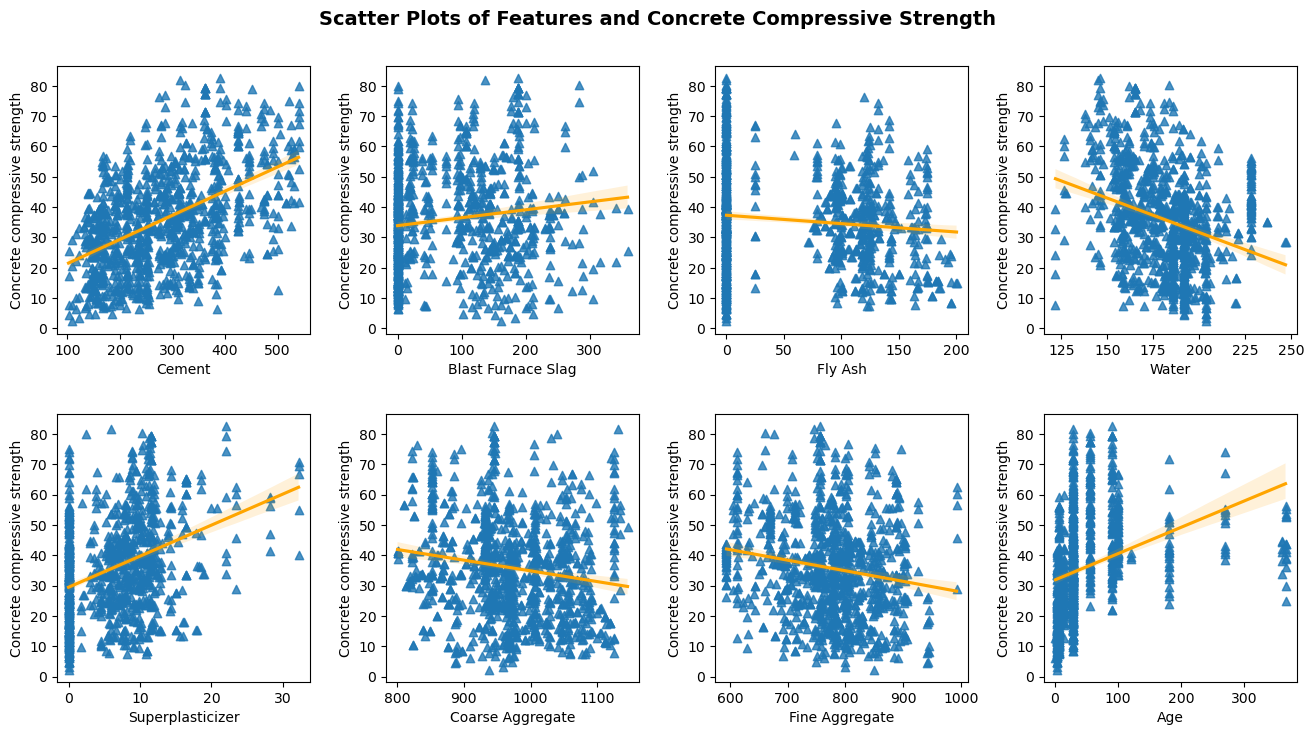

In [3]:
# Plotting Scatter Plots:
def scatter_plots(df, coly, figsize= (4 *4, 2 *4)):
    fig, axes = plt.subplots(2, 4, figsize= figsize)
    for k in range(len(df.columns[:-1])):
        i, j = divmod(k, 4)
        colx = df.columns[k]

        fig = sns.regplot(
            x= colx, y= coly, data= df,
            ax= axes[i][j],
            marker= "^",
            line_kws={'color': "orange"}
        )
    fig = plt.subplots_adjust(wspace= 0.3, hspace= 0.3)
    fig = plt.suptitle(
        "Scatter Plots of Features and Concrete Compressive Strength",
        y= 0.95,
        fontweight= "bold",
        fontsize= 14
    )
    fig = plt.show()

scatter_plots(concrete, "Concrete compressive strength")

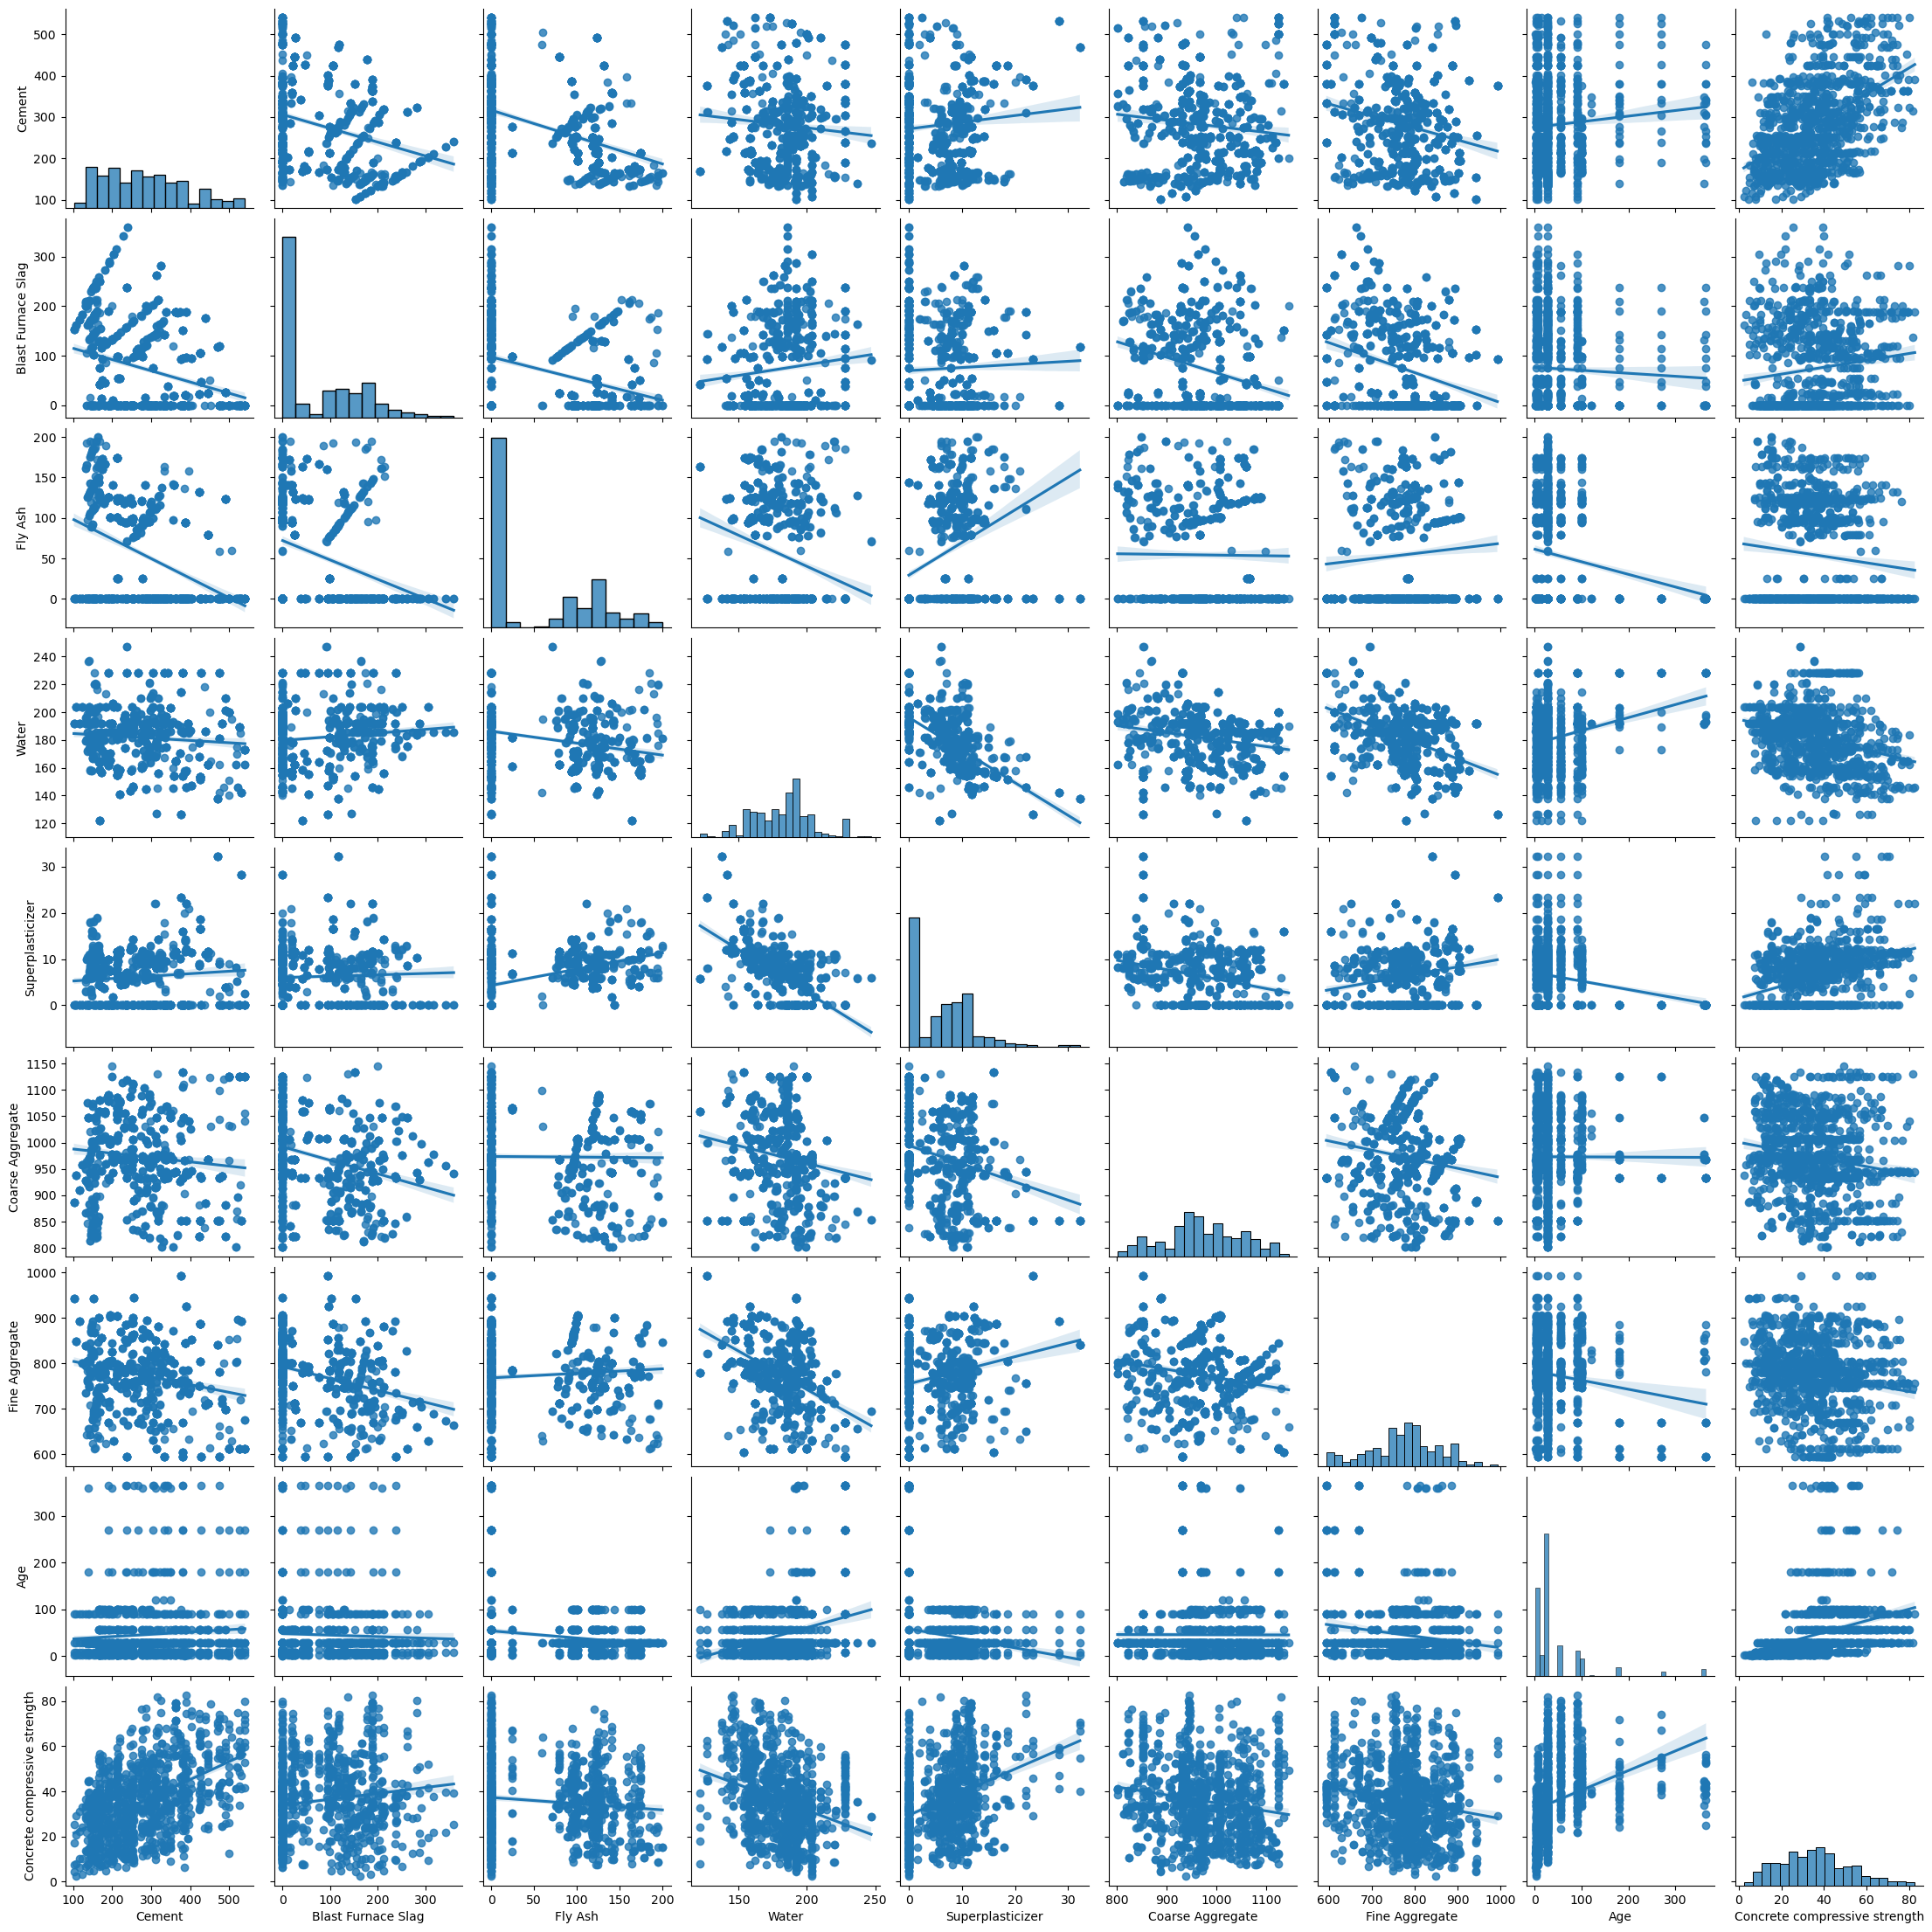

In [4]:
display(
    HTML(
        "<b style='font-size:24pt;'>Pair Scatter Plots</b>"
    )
)
print("\n")
fig_pp = sns.pairplot(concrete, kind= "reg")
fig_pp = plt.show()

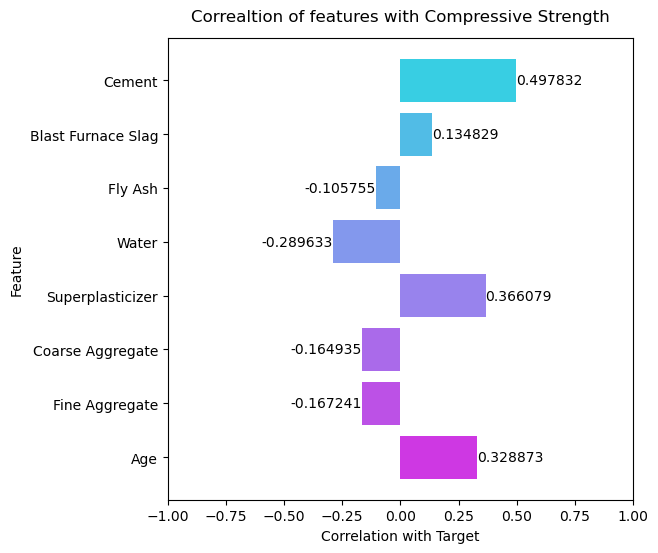

In [4]:
# Correlation between each feature with compressive strength
comp_strength_corr = concrete.corr()["Concrete compressive strength"].copy()
comp_strength_corr = comp_strength_corr.reset_index()
comp_strength_corr = comp_strength_corr.loc[comp_strength_corr.index[:-1], :].copy()
comp_strength_corr.columns = ["Feature", "Correlation with Target"]

fig_cs = plt.figure(figsize= (6, 6))
fig_cs = sns.barplot(
    x= "Correlation with Target",
    y= "Feature",
    data= comp_strength_corr,
    palette= "cool"
)
fig_cs.set_xlim(-1, 1)
fig_cs.set_title(
    "Correaltion of features with Compressive Strength",
    pad= 12
)
fig_cs.bar_label(
            fig_cs.containers[0],
            fontsize= 10
        )
fig_cs = plt.plot()

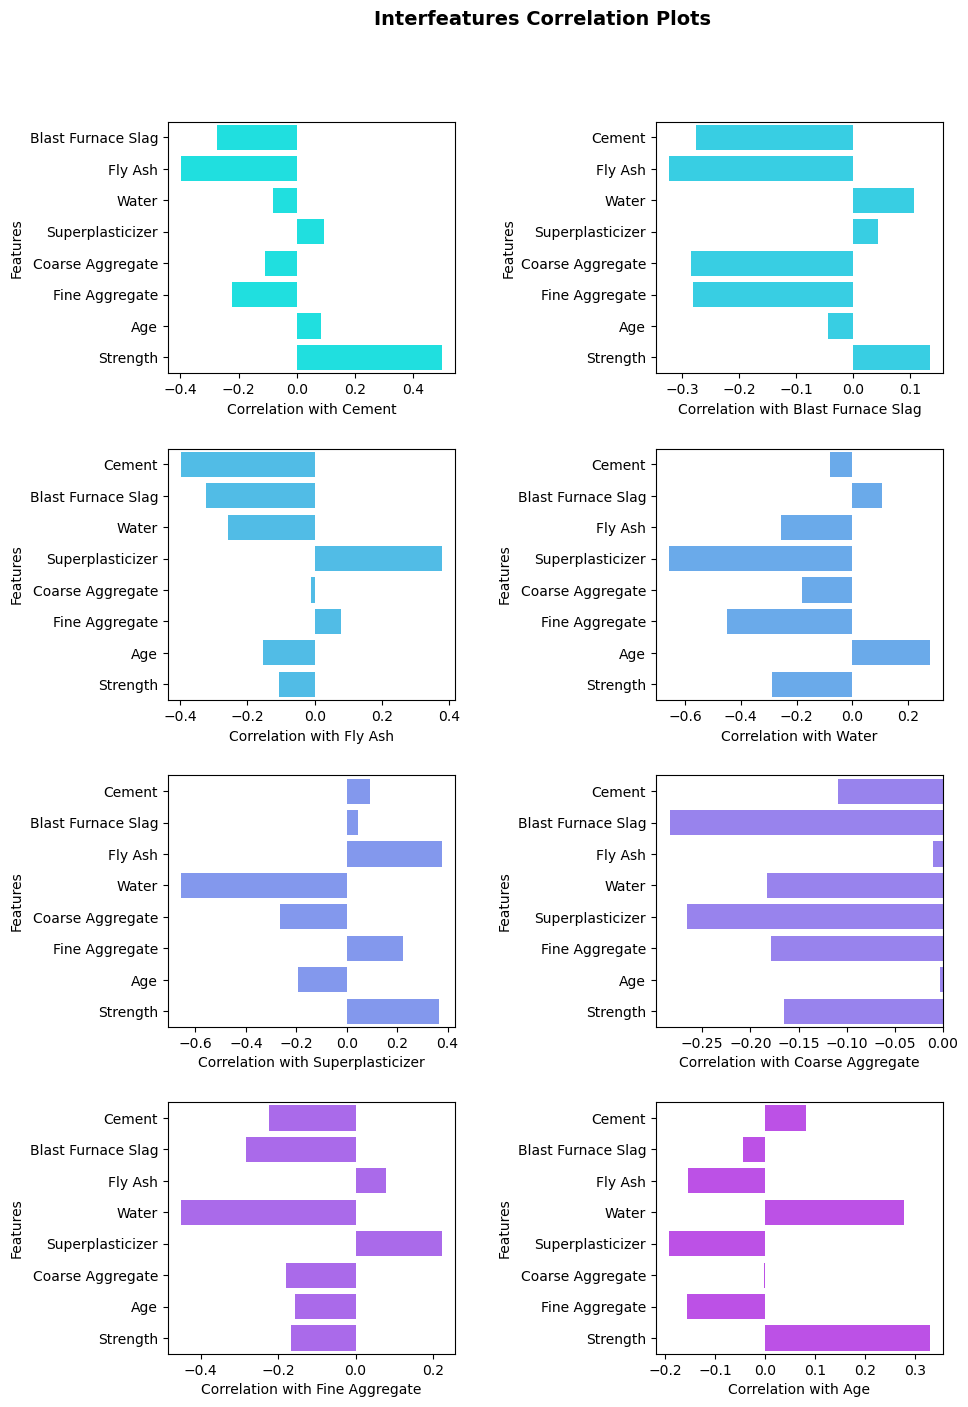

In [5]:
# Interfeatures correlation:
def corr_plots(figsize= (2 *5, 4 *4)):
    df = concrete.copy()
    df = df.rename(columns= {"Concrete compressive strength": "Strength"})
    df_corr = df.corr().copy()
    fig, axes = plt.subplots(4, 2, figsize= figsize)
    coly = df.columns[-1]
    for k in range(len(df_corr.columns[:-1])):
        i, j = divmod(k, 2)
        colx = df_corr.columns[k]
        df_vis = df_corr[colx].reset_index().copy()
        df_vis.columns = ["Features", f"Correlation with {colx}"]
        df_vis = df_vis.drop(index= [k])

        fig = sns.barplot(
            x= f"Correlation with {colx}",
            y= "Features",
            data= df_vis,
            ax= axes[i][j],
            color= plt.cm.cool(k / len(df_corr))
        )

    fig = plt.subplots_adjust(wspace= 0.7, hspace= 0.3)
    fig = plt.suptitle(
        "Interfeatures Correlation Plots",
        y= 0.95,
        fontsize= 14,
        weight= "bold"
    )
    fig = plt.show()

corr_plots()

We will try to create new features from existing features and using the new features in exchange for the corresponding existing features. It can be described as features transformation.

Mathematically, for some $m \in \mathbb{N}$, the feature transformation is given by a map $T: (X_1, \dotsc, X_8) \mapsto (W_1, \dotsc, W_m) \in L^2(P)^m$ such that
$$
\frac{1}{8} \sum_{k = 1}^8 |\mathrm{corr}(X_k, Y)|
\leq \frac{1}{m} \sum_{k = 1}^m |\mathrm{corr}(W_k, Y)|
\,.
$$
Generally, it is favourable if $m \leq 8$, so that the transformed random variables are much simpler than the original random variables. One may use well-known transformation method such as Principal Component Analysis (PCA). However, in this project, we use a much simpler method by obseriving the correlation with $Y$.

According to the EDA, the feature transformation is conducted as follows.

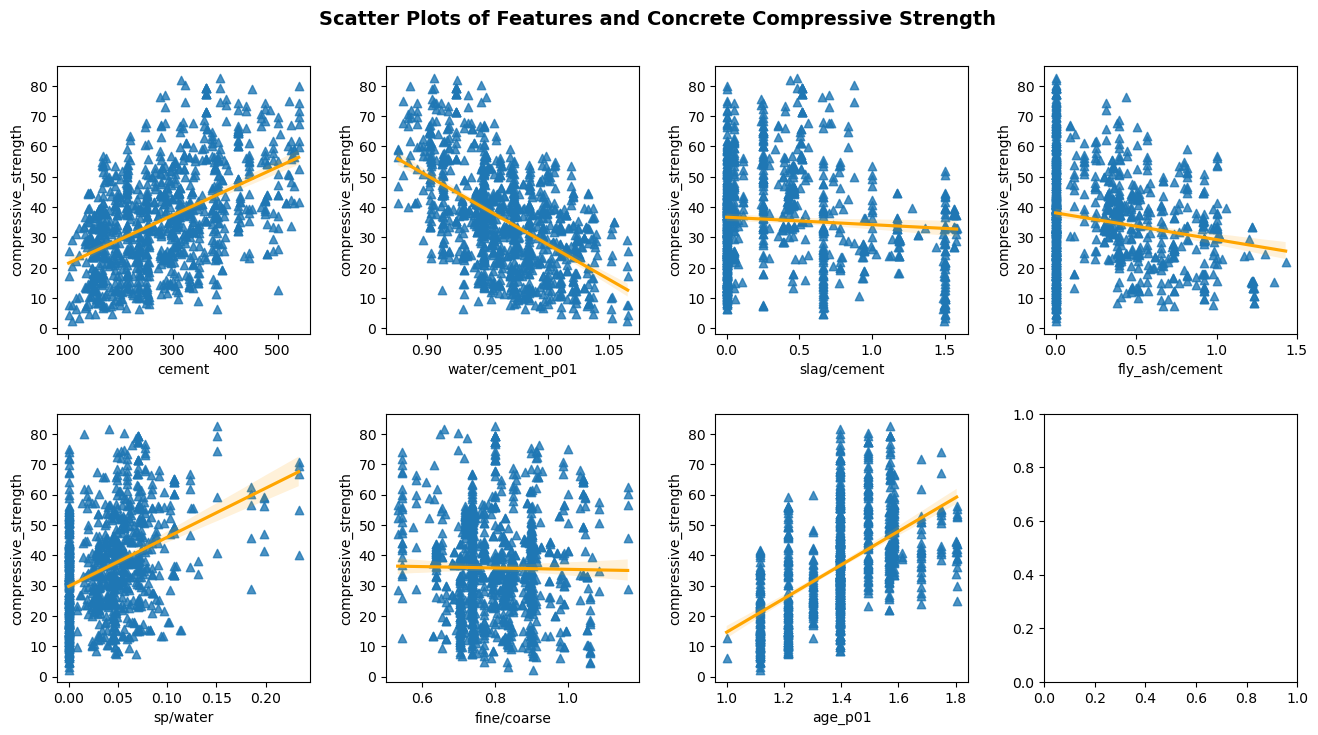

In [6]:
# Feature Engineering
def feature_engineering():
    df = pd.DataFrame()
    df["cement"] = concrete["Cement"]
    df["water/cement_p01"] = (concrete["Water"] / concrete["Cement"])**0.1
    df["slag/cement"] = concrete["Blast Furnace Slag"] / concrete["Cement"]
    df["fly_ash/cement"] = concrete["Fly Ash"] / concrete["Cement"]
    df["sp/water"] = concrete["Superplasticizer"] / concrete["Water"]
    df["fine/coarse"] = concrete["Fine Aggregate"] / concrete["Coarse Aggregate"]
    df["age_p01"] = concrete["Age"]**0.1
    df["compressive_strength"] = concrete["Concrete compressive strength"]
    return df.copy()

conc_fe = feature_engineering().copy()
scatter_plots(conc_fe, "compressive_strength")

In [7]:
conc_fe.corr()["compressive_strength"]

cement                  0.497832
water/cement_p01       -0.542090
slag/cement            -0.069018
fly_ash/cement         -0.181980
sp/water                0.378658
fine/coarse            -0.015486
age_p01                 0.542587
compressive_strength    1.000000
Name: compressive_strength, dtype: float64

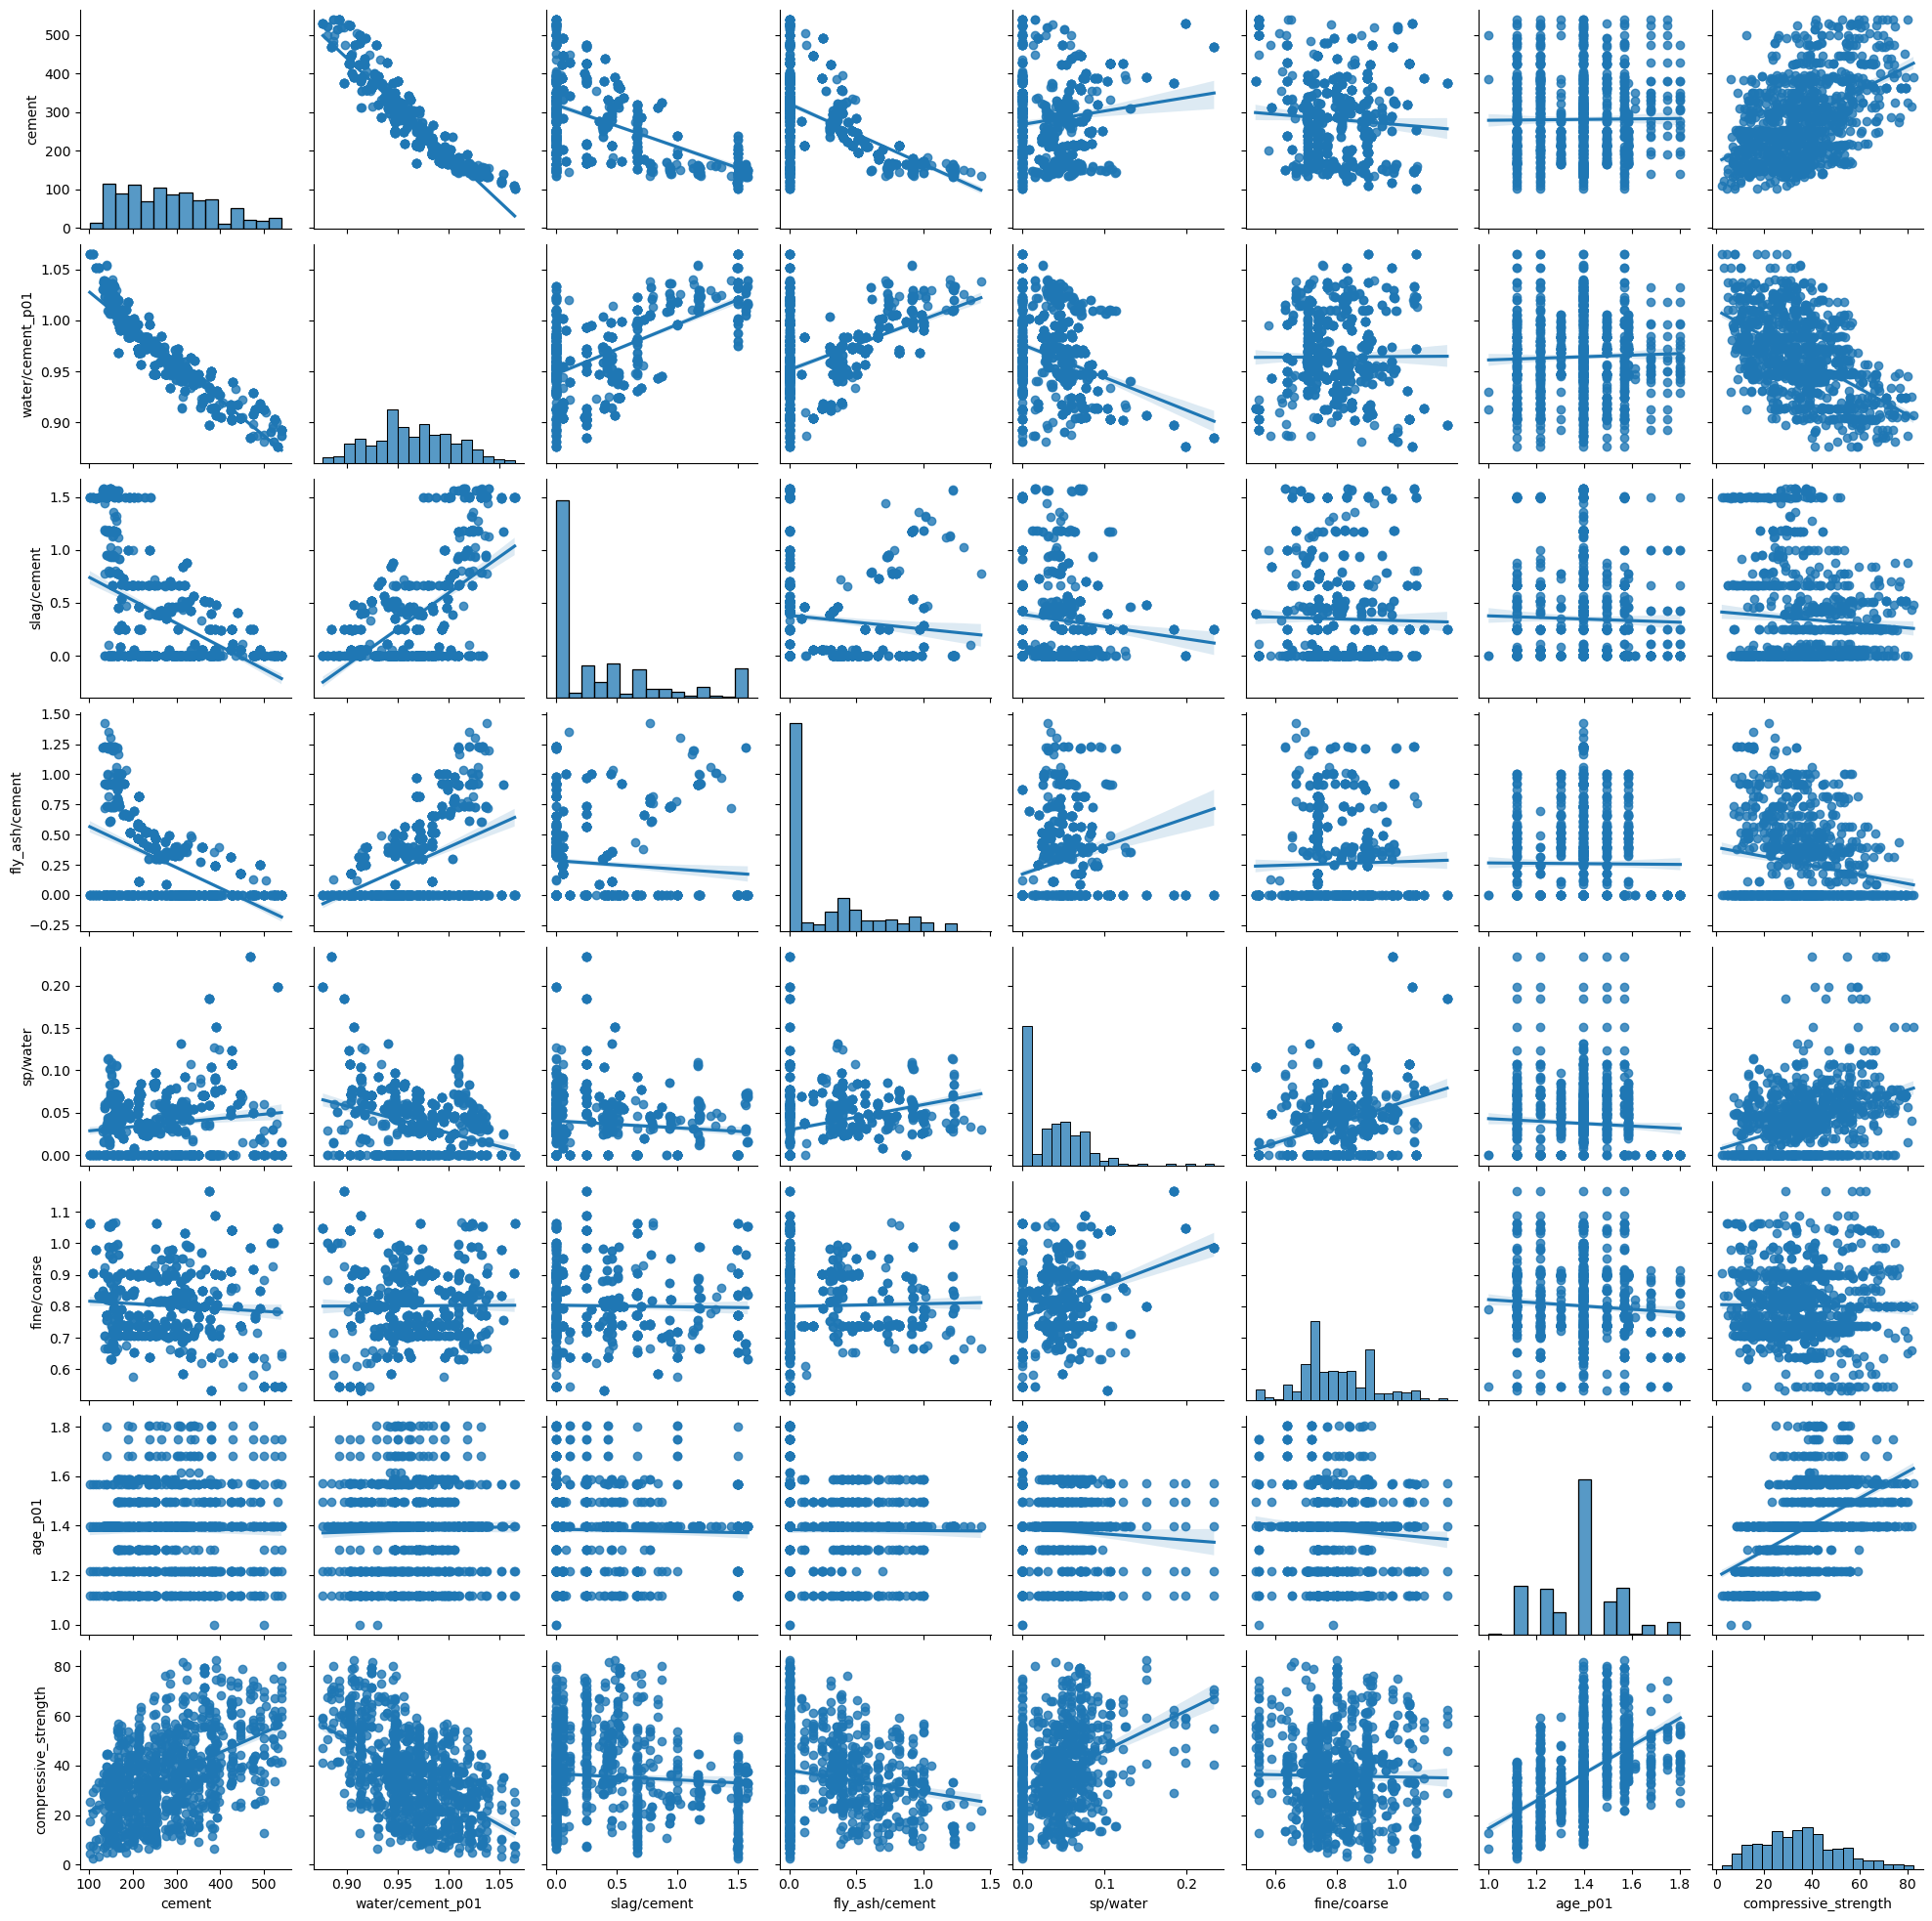

In [7]:
display(
    HTML(
        "<b style='font-size:24pt;'>Pair Scatter Plots of New Features</b>"
    )
)
sns.pairplot(conc_fe, kind= "reg");

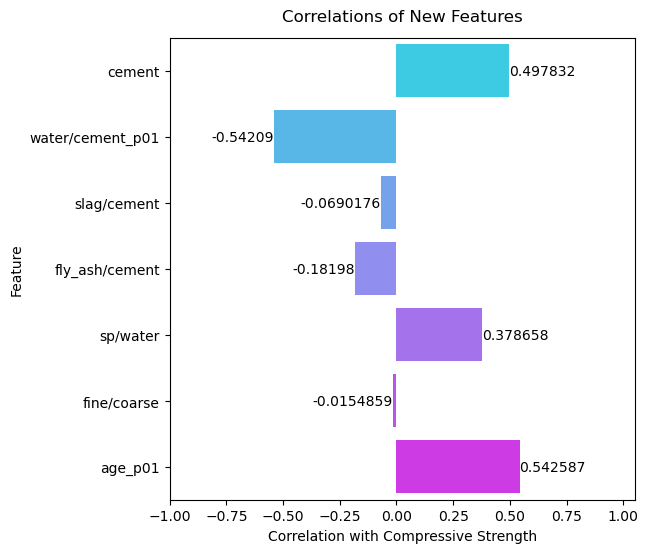

In [8]:
fe_corr = conc_fe.corr()["compressive_strength"].copy()
fe_corr = fe_corr.reset_index()
fe_corr.columns = ["Feature", "Correlation with Compressive Strength"]
fe_corr.drop(index= [len(fe_corr) -1], inplace= True)

fe_fig = plt.figure(figsize= (6, 6))
fe_fig = sns.barplot(
    x= "Correlation with Compressive Strength",
    y= "Feature",
    data= fe_corr,
    palette= "cool"
)
fe_fig.set_xlim(-1, 1.05)
fe_fig.bar_label(
            fe_fig.containers[0],
            fontsize= 10
        )
fe_fig.set_title("Correlations of New Features", pad= 12)
fe_fig = plt.show()

In [9]:
def compare_mean_corr():
    fe = feature_engineering().copy()
    df = concrete.copy()

    fe_corr = fe.corr().abs()["compressive_strength"].copy()
    df_corr = df.corr().abs()["Concrete compressive strength"].copy()

    return df_corr[df_corr.index[:-1]].mean(), fe_corr[fe_corr.index[:-1]].mean()

corr_ori, corr_fe = compare_mean_corr()

display(
    HTML("<b>Computational Result:</b>\n"),
    Markdown(
        r"$\frac{1}{8} \sum_{k = 1}^8 |\mathrm{corr}(X_k, Y)| = $"
        + f" {round(corr_ori, 3)}"
    ),
    Markdown(
        r"$\frac{1}{m} \sum_{k = 1}^m |\mathrm{corr}(W_k, Y)| = $"
        + f" {round(corr_fe, 3)}"
    )
)

$\frac{1}{8} \sum_{k = 1}^8 |\mathrm{corr}(X_k, Y)| = $ 0.257

$\frac{1}{m} \sum_{k = 1}^m |\mathrm{corr}(W_k, Y)| = $ 0.318

In [10]:
# Data Scaling Algorithms
class MinMax:
    def __init__(self):
        pass

    def fit(self, df, columns= None):
        transformations = dict()
        min_vals = dict()
        max_vals = dict()
        if columns is None:
            columns = df.columns
        for col in columns:
            min_vals[col] = df[col].min()
            max_vals[col] = df[col].max()
        self.columns = columns
        self.min_vals = min_vals
        self.max_vals = max_vals

    def transform(self, df):
        mm_df = df.copy()
        for col in self.columns:
            minv = self.min_vals[col]
            maxv = self.max_vals[col]
            mm_df[col] = [
                (x - minv) / (maxv - minv) for x in mm_df[col]
            ]
        return mm_df.copy()

    def fit_transform(self, df, columns= None):
        self.fit(df, columns= columns)
        return self.transform(df)

    def inverse(self, df):
        inv_df = df.copy()
        for col in self.columns:
            minv = self.min_vals[col]
            maxv = self.max_vals[col]
            inv_df[col] = [x *(maxv - minv) + minv for x in inv_df[col]]
        return inv_df.copy()

class StandardScaler:
    def __init__(self):
        pass

    def fit(self, df, columns= None):
        mean_vals = dict()
        std_vals = dict()
        if columns is None:
            columns = df.columns
        for col in columns:
            mean_vals[col] = df[col].mean()
            std_vals[col] = df[col].std()
            
        self.columns = columns
        self.mean_vals = mean_vals
        self.std_vals = std_vals

    def transform(self, df):
        mean_vals = self.mean_vals
        std_vals = self.std_vals
        mm_df = df.copy()
        for col in [c for c in df.columns if c in self.columns]:
            mean = mean_vals[col]
            std = std_vals[col]
            mm_df[col] = [(x - mean) / std for x in mm_df[col]]
        return mm_df.copy()

    def fit_transform(self, df, columns= None):
        self.fit(df, columns= columns)
        return self.transform(df)

## **3. ML Models with DAMSMELRegressor, LinearRegression and SGDRegressor**

Now we build several machine learning models with `DAMSMELRegressor`, `LinearRegression` and `SGDRegressor` and then compare their performances.

We will use a cross validation method to evaluate the performances of the models. We will use 3 trials (or folds) for the cross validation, by randomly split the dataset 60% for training and 40% for validation for each trial.

In [11]:
# Cross Validation Data
def cross_val_data(
        states= [23, 14, 30],
        frac= 0.6,
        scaler= MinMax()
        ):
    df = conc_fe.copy()
    data = list()
    for r in states:
        scaler = MinMax()
        df_train = df.sample(frac= frac, random_state= r).copy()
        df_valid = df.loc[
            [i for i in df.index if i not in df_train.index], :
        ].copy()
        X_train = df_train.drop(columns= ["compressive_strength"]).copy()
        X_train = scaler.fit_transform(X_train)

        X_valid = df_valid.drop(columns= ["compressive_strength"]).copy()
        X_valid = scaler.transform(X_valid)

        data.append(
            {
                "X_train": X_train,
                "X_valid": X_valid,
                "y_train": df_train["compressive_strength"],
                "y_valid": df_valid["compressive_strength"]
                }
        )

    return data

cross_val_datasets = cross_val_data(
    states= [42, 19, 47],
    frac= 0.6,
    scaler= StandardScaler()
)

### **3.1. Training DAMSMEL**

First, we build a machine learning model for `DAMSMELRegressor` and evaluate the cross validation. The algorithm for the `DAMSMELRegressor` can be imported with the following command:
```
from damsmel import DAMSMELRegressor
```

In [12]:
def cross_val_DAMSMEL():
    models = list()
    u0 = np.array([1] *7)
    for itr, cvd in zip(
            range(len(cross_val_datasets)),
            cross_val_datasets
            ):
        model = DAMSMELRegressor(
            15, s= 5,
            alpha= 0.007,
            M= 1300
            )

        X_train, y_train = cvd["X_train"], cvd["y_train"]

        nar = f"\nITERATION-{itr + 1} STARTS"
        print(nar)
        print("=" *len(nar))
        _ = model.fit(
            X_train, y_train,
            u0,
            r= 10**(-5),
            runtime= True,
            verbose= True
            )

        models.append(model)

    return models

models_DAMSMEL = cross_val_DAMSMEL()


ITERATION-1 STARTS
.....Loop 1: 0.06723880767822266 seconds
.....Loop 2: 0.0634603500366211 seconds
.....Loop 3: 0.0645442008972168 seconds
.....Loop 4: 0.06634330749511719 seconds
.....Loop 5: 0.06381797790527344 seconds
.....Loop 6: 0.06464004516601562 seconds
.....Loop 7: 0.06385159492492676 seconds
.....Loop 8: 0.06406116485595703 seconds
.....Loop 9: 0.06327962875366211 seconds
.....Loop 10: 0.06445026397705078 seconds
.....Loop 11: 0.06423401832580566 seconds
.....Loop 12: 0.06409502029418945 seconds
.....Loop 13: 0.0640864372253418 seconds
.....Loop 14: 0.06318950653076172 seconds
.....Loop 15: 0.0637359619140625 seconds
.....Loop 16: 0.06414198875427246 seconds
.....Loop 17: 0.062029123306274414 seconds
.....Loop 18: 0.06291484832763672 seconds
.....Loop 19: 0.06192350387573242 seconds
.....Loop 20: 0.06419968605041504 seconds
.....Loop 21: 0.062279462814331055 seconds
.....Loop 22: 0.06258106231689453 seconds
.....Loop 23: 0.062163352966308594 seconds
.....Loop 24: 0.06483197

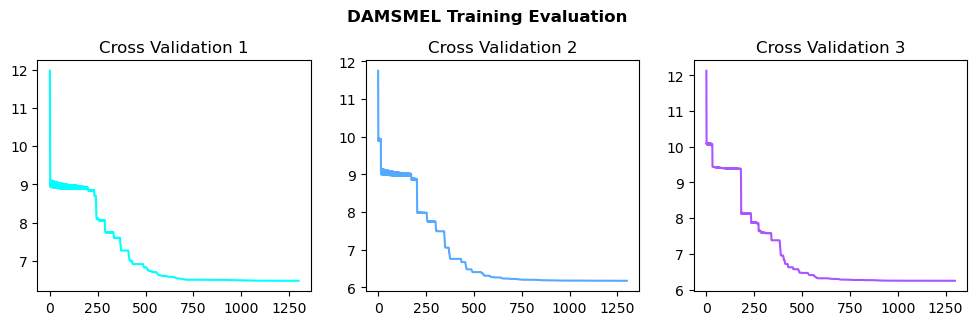

In [13]:
def damsmel_eval(figsize= (12, 3)):
    fig, axs = plt.subplots(1, 3, figsize= figsize)
    for k in range(len(models_DAMSMEL)):
        model = models_DAMSMEL[k]
        fig = model.monitor["loss"].plot(
            ax= axs[k],
            color= plt.cm.cool(k / len(models_DAMSMEL)),
            title= f"Cross Validation {k + 1}"
        )
    fig = plt.suptitle(
        "DAMSMEL Training Evaluation",
        y= 1.05,
        weight= "bold"
    )
    fig = plt.show()

damsmel_eval()

### **3.2. Training `LinearRegression` and `SGDRegressor` Models**

In [14]:
def cross_val_LR():
    models = list()
    for itr, cvd in zip(
            range(len(cross_val_datasets)),
            cross_val_datasets
            ):
        X_train, y_train = cvd["X_train"], cvd["y_train"]
        model = LinearRegression(fit_intercept= False)
        _ = model.fit(X_train, y_train)
        models.append(model)
    return models

def cross_val_SGD():
    models = list()
    for itr, cvd in zip(
            range(len(cross_val_datasets)),
            cross_val_datasets
            ):
        X_train, y_train = cvd["X_train"], cvd["y_train"]
        model = SGDRegressor(fit_intercept= False)
        _ = model.fit(X_train, y_train)
        models.append(model)
    return models

models_LR = cross_val_LR()
models_SGD = cross_val_SGD()

## **4. Comparison**

In [15]:
# Comparison

def train_MAE(
        visualize= False,
        figsize= (8, 6),
        color= "blue",
        ax= None
        ):
    cv_mae_DAMSMEL = list()
    cv_mae_LR = list()
    cv_mae_SGD = list()

    for k, cvd in zip(range(len(cross_val_datasets)), cross_val_datasets):
        X_train = cvd["X_train"]
        y_train = cvd["y_train"]
        y_pred_DAMSMEL = models_DAMSMEL[k].predict(X_train)
        y_pred_LR = models_LR[k].predict(X_train)
        y_pred_SGD = models_SGD[k].predict(X_train)

        for cv_mae, y_pred in zip(
                [cv_mae_DAMSMEL, cv_mae_LR, cv_mae_SGD],
                [y_pred_DAMSMEL, y_pred_LR, y_pred_SGD]
                ):
            cv_mae.append(
                np.mean([abs(a - b) for a, b in zip(y_train, y_pred)])
            )
    
    eval_all = pd.DataFrame(
        {
            "regressor": ["DAMSMEL", "LinearRegression", "SGDRegressor"],
            "cross_val_mae": [
                np.mean(cv_mae_DAMSMEL), np.mean(cv_mae_LR), np.mean(cv_mae_SGD)
            ]
        }
    )

    if visualize == True:
        fig = plt.figure()
        fig = eval_all.plot.bar(
            x= "regressor", y= "cross_val_mae",
            color= color,
            figsize= figsize,
            ax= ax
        )
        fig = plt.plot()
    else:
        return eval_all.copy()

def valid_MAE(
        visualize= False,
        figsize= (8, 6),
        color= "blue",
        ax= None
        ):
    cv_mae_DAMSMEL = list()
    cv_mae_LR = list()
    cv_mae_SGD = list()

    for k, cvd in zip(range(len(cross_val_datasets)), cross_val_datasets):
        X_valid = cvd["X_valid"]
        y_valid = cvd["y_valid"]
        y_pred_DAMSMEL = models_DAMSMEL[k].predict(X_valid)
        y_pred_LR = models_LR[k].predict(X_valid)
        y_pred_SGD = models_SGD[k].predict(X_valid)

        for cv_mae, y_pred in zip(
                [cv_mae_DAMSMEL, cv_mae_LR, cv_mae_SGD],
                [y_pred_DAMSMEL, y_pred_LR, y_pred_SGD]
                ):
            cv_mae.append(
                np.mean([abs(a - b) for a, b in zip(y_valid, y_pred)])
            )

    eval_all = pd.DataFrame(
        {
            "regressor": ["DirectioNSMEL", "LinearRegression", "SGDRegressor"],
            "cross_val_mae": [
                np.mean(cv_mae_DAMSMEL), np.mean(cv_mae_LR), np.mean(cv_mae_SGD)
            ]
        }
    )

    if visualize == True:
        fig = plt.figure()
        fig = eval_all.plot.bar(
            x= "regressor", y= "cross_val_mae",
            color= color,
            figsize= figsize,
            ax= None
        )
        fig = plt.plot()
    else:
        return eval_all.copy()

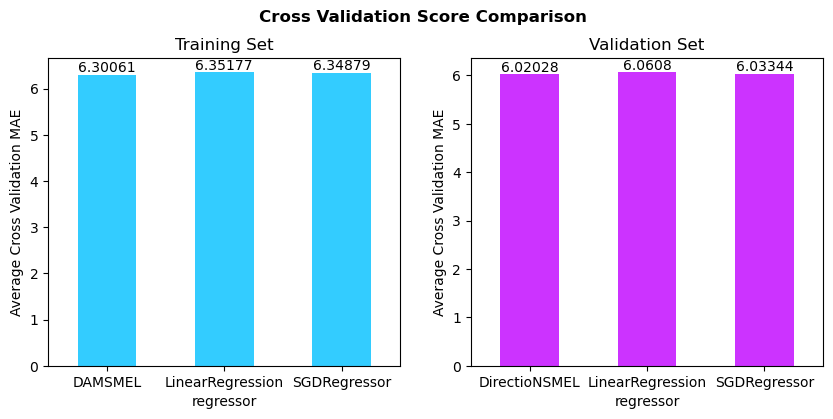

In [16]:
cross_val_vis, axs = plt.subplots(1, 2, figsize= (10, 4))

cross_val_vis = train_MAE(visualize= False).plot.bar(
    x= "regressor", y= "cross_val_mae",
    ax= axs[0],
    color= plt.cm.cool(0.2),
    legend= False,
    title= "Training Set",
    ylabel= "Average Cross Validation MAE",
    rot= 0
)
axs[0].bar_label(
            axs[0].containers[0],
            fontsize= 10
        )
cross_val_viz = valid_MAE(visualize= False).plot.bar(
    x= "regressor", y= "cross_val_mae",
    ax= axs[1],
    color= plt.cm.cool(0.8),
    legend= False,
    title= "Validation Set",
    ylabel= "Average Cross Validation MAE",
    rot= 0
)
axs[1].bar_label(
            axs[1].containers[0],
            fontsize= 10
        )
cross_val_viz = plt.suptitle(
    "Cross Validation Score Comparison",
    y= 1,
    weight= "bold"
)
# cross_val_viz = plt.savefig("Cross-validation-result.png")
cross_val_viz = plt.show()